In [54]:
import os
from pydub import AudioSegment
import librosa
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [55]:
# 将 m4a 格式转换为 wav 格式
def formatConvert(audio_path, audio_format):
    audio_name = os.path.splitext(audio_path)[0]
    audio = AudioSegment.from_file(audio_path, format=audio_format)
    audio.export(audio_name + ".wav", format="wav")

In [56]:
formatConvert("audio/shop.m4a", "m4a")

预加重的好处：

1. 语音信号的高频部分（如辅音）通常比低频部分（如元音）能量弱。

2. 高频部分包含许多重要的语音特征信息。

3. 预加重可以提升高频分量，使整个频谱更加平坦，便于后续分析。

预加重的原理是一个简单的高通滤波器：

$$
H(z) = 1 - \alpha z^{-1}
$$

假设原输入信号为 $x[n]$，预加重后的信号为 $y[n]$，则有：

$$
Y(z) = H(z)X(z) = (1 - \alpha z^{-1})X(z) = X(z) - \alpha z^{-1}X(z)
$$

那么，

$$
y[n] = x[n] - \alpha x[n-1]
$$

In [57]:
# 预加重
def preEmphasis(x, alpha=0.97):
    return np.append(x[0], x[1:] - alpha * x[:-1])

In [58]:
def FFT(x):

    x = np.asarray(x, dtype=complex)
    N = len(x)
    assert N > 0 and (N & (N - 1)) == 0, "N must be a power of 2"
    
    if N <= 1:
        return x
    
    # X(k) = G(k) + e^(-2πk/N) H(k)
    G = FFT(x[0::2])     # g(r) = x(2r)
    H = FFT(x[1::2])      # h(r) = x(2r+1)
    
    # 旋转因子列表
    # W1, W2, ..., W(N/2-1)
    W = np.exp(-2j * np.pi * np.arange(N // 2) / N)
    
    # 
    X = np.zeros(N, dtype=complex)
    X[:N//2] = G + W * H
    X[N//2:] = G - W * H
    
    return X

In [59]:
# 计算 STFT
# y: 音频信号
# sr: 采样率
# win: 窗口大小
# step: 步长
def STFT(y, sr, win, step):
    # 分帧
    frames = []
    for i in range(0, len(y) - win, step):
        frame = np.hanning(win) * y[i:i + win]
        frames.append(frame)
    
    # 计算 STFT
    stft = []
    for frame in frames:
        # 计算 FFT
        fft = FFT(frame)
        stft.append(np.abs(fft[:win // 2 + 1])) # 幅值取绝对值，只关心正频率
    
    # 转置为 (频率, 时间) 形式
    return np.array(stft).T

Mel 滤波器是一组三角形带通滤波器，排列在 Mel 频率刻度上，用于将线性频谱转换为（符合人耳感知的）Mel 频谱。

- 数量：通常 20-40 个（常用26个）

- ​分布：在 Mel 频率刻度上非均匀分布（低频密集，高频稀疏）

- ​形状：三角形，相邻滤波器有 50% 的重叠区域

In [60]:
def hz2mel(hz):
    return 2595 * np.log10(1 + hz / 700)

def mel2hz(mel):
    return 700 * (10**(mel / 2595) - 1)

In [61]:
# Mel 滤波器组
def melFilterBank(sr, n_fft, n_filter):
    min_hz = 0
    max_hz = sr / 2

    min_mel = hz2mel(min_hz)
    max_mel = hz2mel(max_hz)

    # 在梅尔刻度上均匀分布
    mel_points = np.linspace(min_mel, max_mel, n_filter + 2)
    hz_points = mel2hz(mel_points)

    indices = np.floor((n_fft + 1) * hz_points / sr).astype(int)    # 在 FFT 结果数组中的索引

    # 空滤波器组
    filterbank = np.zeros((n_filter, n_fft // 2 + 1))

    # 构建每一个滤波器
    for i in range(n_filter):
        left = indices[i]
        center = indices[i+1]
        right = indices[i+2]

        # 三角形滤波器
        for j in range(left, center):
            filterbank[i][j] = (j - left) / (center - left)
        for j in range(center, right):
            filterbank[i][j] = (right - j) / (right - center)

    return filterbank

In [62]:
# 计算 MFCC
# y: 音频信号
# sr: 采样率
# N: 窗口大小
# D: MFCC系数数量，通常为 12~16
# M: Mel 滤波器组数量，通常为 20~40
def computeMFCC(y, sr, N, D=13, M=26):
    # 预加重
    y_ = preEmphasis(y)

    # 分帧 + STFT
    spec = STFT(y_, sr, N, N//2)                # (频率, 窗口)

    # 转换为功率谱
    power_spec = np.square(spec) / N            # (频率, 窗口)

    # 应用 Mel 滤波器组
    filter_bank = melFilterBank(sr, N, M)
    mel_spec = np.dot(filter_bank, power_spec)  # (滤波器数量, 窗口)

    # 离散余弦变换(DCT)
    log_mel_spec = np.log(mel_spec + 1e-10)     # 取对数
    mfcc = np.zeros((D, log_mel_spec.shape[1])) # (系数数量, 窗口数量)
    for i in range(D):
        for j in range(M):
            mfcc[i] += log_mel_spec[j] * np.cos(np.pi * (j - 0.5) * i / M)

    return mfcc

In [63]:
# 打印 MFCC
def printMFCC(mfcc, max_frames=10):
    n_coeffs, n_frames = mfcc.shape
    frames_to_show = min(max_frames, n_frames)
    
    data = mfcc[:, :frames_to_show]
    
    df = pd.DataFrame(
        data, 
        index=[f"MFCC {i}" for i in range(n_coeffs)],
        columns=[f"frame{i+1}" for i in range(frames_to_show)]
    )
    
    # 设置显示格式
    pd.set_option('display.width', 200)       # 增加显示宽度
    pd.set_option('display.max_columns', None) # 显示所有列
    pd.set_option('display.precision', 2)      # 设置小数精度
    
    # 显示表格
    print("总共有 %d 帧，这里显示前 %d 帧" % (n_frames, frames_to_show))
    print("MFCC 系数数量: %d" % n_coeffs)
    print(df)

In [64]:
# 可视化MFCC
def visualizeMFCC(mfcc):
    plt.figure(figsize=(12, 6))
    plt.imshow(mfcc, cmap='viridis')
    plt.colorbar()
    plt.title("MFCC")
    plt.xlabel("frame")
    plt.ylabel("MFCC coefficients")
    plt.tight_layout()
    plt.show()

In [65]:
sample_rate = 8000
y, _ = librosa.load("audio/shop.wav", sr=sample_rate)
mfcc = computeMFCC(y, sample_rate, 512, D=13, M=26)

In [66]:
printMFCC(mfcc, 10)

总共有 66 帧，这里显示前 10 帧
MFCC 系数数量: 13
         frame1  frame2  frame3  frame4  frame5  frame6  frame7  frame8  frame9  frame10
MFCC 0  -563.95 -383.09 -344.04 -315.49 -306.13 -306.10 -304.32 -304.68 -299.27  -300.50
MFCC 1   -62.14  -43.99  -40.47  -35.67  -34.95  -35.29  -34.17  -36.31  -34.47   -35.28
MFCC 2     3.44   -1.71   -6.77   -1.05   -6.02   -5.29   -4.67   -4.22   -6.01    -5.56
MFCC 3   -42.55  -29.96  -29.33  -26.91  -26.54  -22.32  -22.77  -20.97  -17.97   -23.34
MFCC 4    -3.91   -0.14   -3.02   -4.32   -6.57    0.67    1.35   -1.26   -0.71    -3.95
MFCC 5   -40.55  -21.19  -25.38  -21.39  -24.74  -19.58  -19.59  -19.88  -23.04   -24.16
MFCC 6    -5.41   -5.42   -7.22   -7.05   -8.08   -6.82   -4.79   -5.25   -5.05    -7.58
MFCC 7   -36.91  -32.52  -26.32  -26.23  -26.63  -23.15  -26.03  -24.57  -26.01   -26.33
MFCC 8    -3.25   -7.22   -0.99   -1.75   -5.89   -4.05   -6.33   -3.92   -3.65    -1.87
MFCC 9   -37.94  -27.62  -24.36  -22.19  -22.76  -24.95  -24.52  -21.99  -23

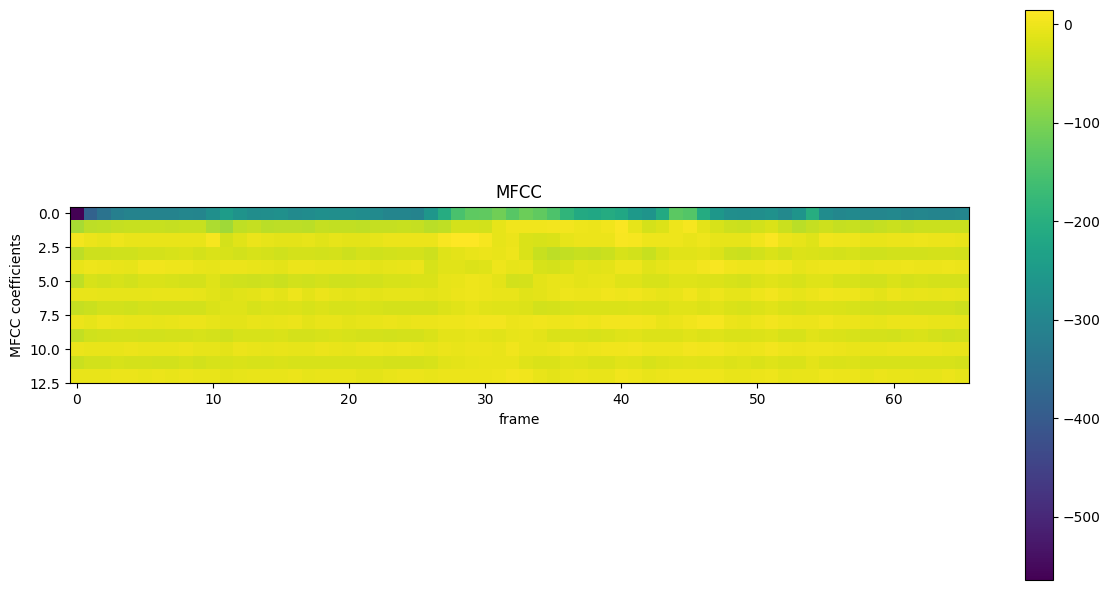

In [67]:
visualizeMFCC(mfcc)